## 序列模型
- 音乐、语言、文本、视频都是连续的
- 大地震发生后，可能会有几次小的余震
- 总结: 当前数据和历史数据相关

## 统计工具
- 之前进行的图片分类，图片之间是互相独立的
- 联合概率可以用条件概率展开
![softmax-description](./imgs/51-1.png)
- 统计方法:前向+后向

## 序列模型
1. 自回归模型: 核心-如何计算f
![softmax-description](./imgs/51-2.png)
2. 自回归的相关假设:
- 方案A: 马尔科夫假设: 
- 假设当前的数据只跟过去$\tau$个过去数据点相关->简化模型:固定长度
![softmax-description](./imgs/51-3.png)
- 方案B: 潜变量模型:h可以不断更新->用潜变量来概括历史信息
![softmax-description](./imgs/51-4.png)

In [2]:
%matplotlib inline
import torch
from torch import nn
import d2l

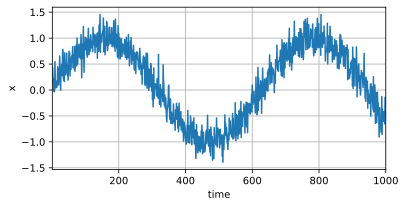

In [3]:
# 数据生成
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [4]:
# 这里将数据组成数据对: 
tau = 4 
#  T - tau个训练样本，每个样本有tau个特征
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i] # 每一个label对应前面tou个样本
labels = x[tau:].reshape((-1, 1)) # 

batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight) # xavier_uniform_只是写在这里

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失
loss = nn.MSELoss()

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [ ]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

In [ ]:
onestep_preds = net(features) # 给定一个长为4的数据，预测下一个数据
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [ ]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [ ]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

# 预测未来一个点效果还可以，预测未来64个点就不行了
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))